# **Import Library**

In [58]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
from kneed import KneeLocator
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Dicky
[nltk_data]     Zulfikar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Load Dataset**

In [2]:
df = pd.read_csv("data/shopee_dataset.csv")
df.head()

,link,gambar,nama_produk,harga,diskon,rating,kota,deskripsi
0,https://shopee.co.id/Madu-Uray-Grade-A-875gr-R...,https://down-id.img.susercontent.com/file/id-1...,Madu Uray Grade A+ 875gr Royal Jelly & Bee Pollen,142.4,-15%,4.9,KOTA SURABAYA,"Madu favorit Anda, minuman kesehatan alami sek..."
1,https://shopee.co.id/Kurma-Sukari-King-Dates-S...,https://down-id.img.susercontent.com/file/id-1...,Kurma Sukari King Dates Sukkari 1 Kg Lembut Ma...,59.0,-31%,4.8,KOTA BOGOR,Makanan ringan sehat buah Kurma Sukkari Al Qas...
2,https://shopee.co.id/Dari-Bumi-Madu-Murni-Akas...,https://down-id.img.susercontent.com/file/id-1...,Dari Bumi Madu Murni Akasia 650 Gr Raw Honey Asli,57.9,-50%,4.9,KOTA JAKARTA BARAT,Minuman kesehatan alami madu murni Akasia Dari...
3,https://shopee.co.id/CAP-IBU-Bumbu-Nasi-Goreng...,https://down-id.img.susercontent.com/file/id-1...,CAP IBU Bumbu Nasi Goreng Kecap,38.0,-5%,4.9,KOTA JAKARTA TIMUR,Bumbu masakan instan Bumbu Nasi Goreng Kecap C...
4,https://shopee.co.id/Pronas-Luncheon-Sapi-(Dag...,https://down-id.img.susercontent.com/file/id-1...,Pronas Luncheon Sapi (Daging Blok Serbaguna) 3...,44.4,-15%,4.9,KOTA BEKASI,Pronas Luncheon Sapi (Daging Blok Serbaguna) 3...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   link         456 non-null    object 
 1   gambar       456 non-null    object 
 2   nama_produk  456 non-null    object 
 3   harga        456 non-null    float64
 4   diskon       337 non-null    object 
 5   rating       455 non-null    float64
 6   kota         456 non-null    object 
 7   deskripsi    456 non-null    object 
dtypes: float64(2), object(6)
memory usage: 28.6+ KB


In [4]:
df.describe()

,harga,rating
count,456.000000,455.000000
mean,51.829910,4.899560
std,76.162675,0.049667
min,1.710000,4.600000
25%,14.300000,4.900000
50%,24.950000,4.900000
75%,57.405000,4.900000
max,800.000000,5.000000


# **Exploratory Data Analysis**

## a)  Visualisasi distribusi harga dan rating

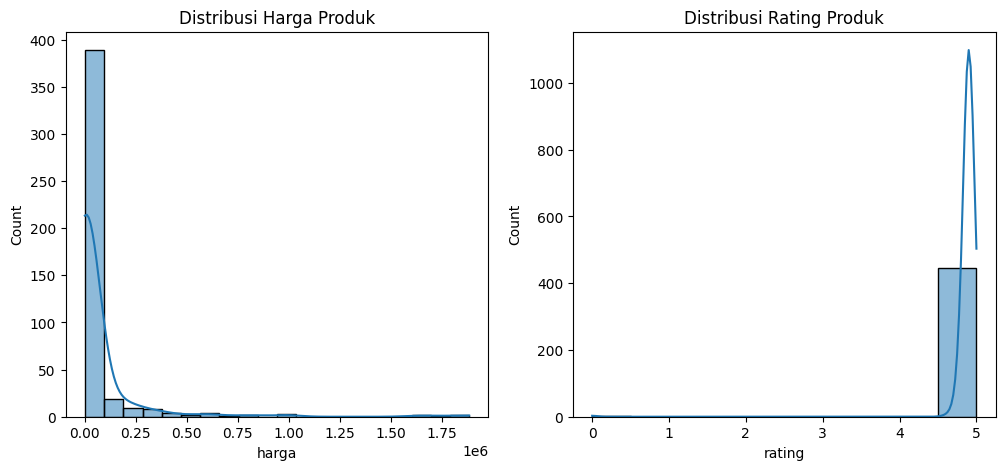

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['harga'], bins=20, kde=True)
plt.title('Distribusi Harga Produk')
plt.subplot(1,2,2)
sns.histplot(df['rating'], bins=10, kde=True)
plt.title('Distribusi Rating Produk')
plt.show()

## b) Visualisasi jumlah produk per kota

C:\Users\Dicky Zulfikar\AppData\Local\Temp\ipykernel_12496\1717674609.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




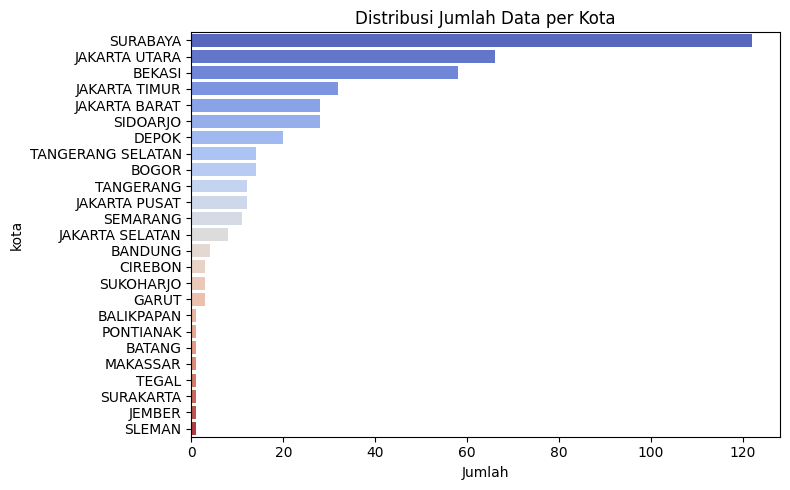

In [68]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y='kota', order=df['kota'].value_counts().index, palette='coolwarm')
plt.title('Distribusi Jumlah Data per Kota')
plt.xlabel('Jumlah')
plt.ylabel('kota')
plt.tight_layout()
plt.show()

## c) Visualisasi korelasi harga dengan rating

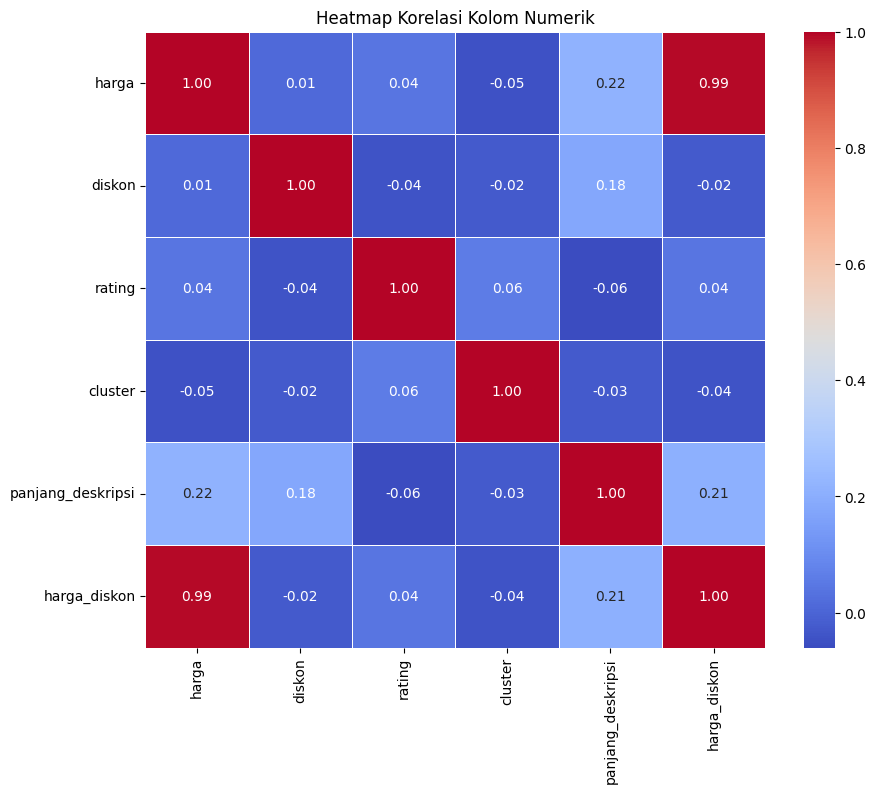

In [ ]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap Korelasi Kolom Numerik')
plt.show()

# **Preprocessing**

## a) Menangani Missing Values (NaN)

In [5]:
df.isnull().sum()

link             0
gambar           0
nama_produk      0
harga            0
diskon         119
rating           1
kota             0
deskripsi        0
dtype: int64

In [6]:
df['diskon'] = df['diskon'].fillna('0%')
df['rating'].fillna(0, inplace=True)
print(df.isnull().sum())

link           0
gambar         0
nama_produk    0
harga          0
diskon         0
rating         0
kota           0
deskripsi      0
dtype: int64


## b) Menangani Duplikasi Data

In [7]:
# Mengecek duplikat yang sama persis
df[df.duplicated(keep=False)]

,link,gambar,nama_produk,harga,diskon,rating,kota,deskripsi
263,https://shopee.co.id/Sasa-Tepung-Ayam-Kentucky...,https://down-id.img.susercontent.com/file/id-1...,Sasa Tepung Ayam Kentucky Bervitamin & Bermine...,20.038,-10%,4.9,KOTA JAKARTA TIMUR,Sasa Tepung Ayam Kentucky Bervitamin & Bermine...
309,https://shopee.co.id/Sasa-Tepung-Ayam-Kentucky...,https://down-id.img.susercontent.com/file/id-1...,Sasa Tepung Ayam Kentucky Bervitamin & Bermine...,20.038,-10%,4.9,KOTA JAKARTA TIMUR,Sasa Tepung Ayam Kentucky Bervitamin & Bermine...


In [8]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
# Melihat variasi lain pada duplikat berdasarkan 'nama_produk'
df[df.duplicated('nama_produk', keep=False)].sort_values('nama_produk')

,link,gambar,nama_produk,harga,diskon,rating,kota,deskripsi
346,https://shopee.co.id/Crystal-of-the-Sea-Salmon...,https://down-id.img.susercontent.com/file/id-1...,Crystal of the Sea | Salmon Powder (20GR) (80G...,75.00,0%,4.9,KOTA SURABAYA,Crystal of the Sea | Salmon Powder (20GR) (80G...
262,https://shopee.co.id/Crystal-of-the-Sea-Salmon...,https://down-id.img.susercontent.com/file/id-1...,Crystal of the Sea | Salmon Powder (20GR) (80G...,75.00,0%,4.9,KOTA SURABAYA,Salmon Powder 80gr / Bubuk Ikan Salmon - Bumbu...
307,https://shopee.co.id/Flimbar-(Snack-Sehat)-by-...,https://down-id.img.susercontent.com/file/id-1...,Flimbar (Snack Sehat) by Flimty - 1 Box (Isi 1...,99.75,-5%,4.9,KOTA JAKARTA UTARA,Flimbar (Snack Sehat) by Flimty - 1 Box (Isi 1...
276,https://shopee.co.id/Flimbar-(Snack-Sehat)-by-...,https://down-id.img.susercontent.com/file/id-1...,Flimbar (Snack Sehat) by Flimty - 1 Box (Isi 1...,99.75,-5%,4.9,KOTA JAKARTA UTARA,Flimbar (Snack Sehat) by Flimty merupakan maka...
248,https://shopee.co.id/HiLo-Gold-Original-1000-G...,https://down-id.img.susercontent.com/file/id-1...,HiLo Gold Original 1000 Gram - Susu Tinggi Kal...,160.20,-16%,4.9,KOTA JAKARTA UTARA,HiLo Gold Original 1000 Gram adalah susu tingg...
301,https://shopee.co.id/HiLo-Gold-Original-1000-G...,https://down-id.img.susercontent.com/file/id-1...,HiLo Gold Original 1000 Gram - Susu Tinggi Kal...,159.90,-16%,4.9,KOTA JAKARTA UTARA,HiLo Gold Original 1000 Gram adalah susu tingg...
325,https://shopee.co.id/HiLo-School-Susu-Strawber...,https://down-id.img.susercontent.com/file/id-1...,HiLo School Susu Strawberry 10 Sachet - Susu T...,37.30,-21%,4.9,KOTA JAKARTA UTARA,HiLo School Minuman Susu Strawberry 10 Sachet ...
242,https://shopee.co.id/HiLo-School-Susu-Strawber...,https://down-id.img.susercontent.com/file/id-1...,HiLo School Susu Strawberry 10 Sachet - Susu T...,37.30,-21%,4.9,KOTA JAKARTA UTARA,HiLo School Susu Strawberry 10 Sachet adalah s...
1,https://shopee.co.id/Kurma-Sukari-King-Dates-S...,https://down-id.img.susercontent.com/file/id-1...,Kurma Sukari King Dates Sukkari 1 Kg Lembut Ma...,59.00,-31%,4.8,KOTA BOGOR,Makanan ringan sehat buah Kurma Sukkari Al Qas...
419,https://shopee.co.id/Kurma-Sukari-King-Dates-S...,https://down-id.img.susercontent.com/file/id-1...,Kurma Sukari King Dates Sukkari 1 Kg Lembut Ma...,59.00,-31%,4.8,KOTA BOGOR,Kurma Sukari King Dates Sukkari 1 Kg Lembut Ma...


In [10]:
# menghapus duplikat berdasarkan nama_produk dan kota
df = df.drop_duplicates(subset=['nama_produk', 'kota'])
df[df.duplicated('nama_produk', keep=False)].sort_values('nama_produk')

,link,gambar,nama_produk,harga,diskon,rating,kota,deskripsi
77,https://shopee.co.id/Tong-Tji-Jasmine-Tea-Sach...,https://down-id.img.susercontent.com/file/sg-1...,"Tong Tji Jasmine Tea Sachet, Teh Celup Per Ren...",17.6,-20%,5.0,KOTA BANDUNG,Tong Tji Jasmine Tea (Teh Melati Celup) adalah...
230,https://shopee.co.id/Tong-Tji-Jasmine-Tea-Sach...,https://down-id.img.susercontent.com/file/sg-1...,"Tong Tji Jasmine Tea Sachet, Teh Celup Per Ren...",17.6,-20%,5.0,KAB. SEMARANG,Tong Tji Jasmine Tea Sachet adalah teh melati ...


## c) Penanganan Kolom 'harga'

In [11]:
df['harga'] = df['harga'].astype(str).str.replace('.', '', regex=False).astype(int)
df['harga'] = df['harga'] * 10
df.head()

,link,gambar,nama_produk,harga,diskon,rating,kota,deskripsi
0,https://shopee.co.id/Madu-Uray-Grade-A-875gr-R...,https://down-id.img.susercontent.com/file/id-1...,Madu Uray Grade A+ 875gr Royal Jelly & Bee Pollen,14240,-15%,4.9,KOTA SURABAYA,"Madu favorit Anda, minuman kesehatan alami sek..."
1,https://shopee.co.id/Kurma-Sukari-King-Dates-S...,https://down-id.img.susercontent.com/file/id-1...,Kurma Sukari King Dates Sukkari 1 Kg Lembut Ma...,5900,-31%,4.8,KOTA BOGOR,Makanan ringan sehat buah Kurma Sukkari Al Qas...
2,https://shopee.co.id/Dari-Bumi-Madu-Murni-Akas...,https://down-id.img.susercontent.com/file/id-1...,Dari Bumi Madu Murni Akasia 650 Gr Raw Honey Asli,5790,-50%,4.9,KOTA JAKARTA BARAT,Minuman kesehatan alami madu murni Akasia Dari...
3,https://shopee.co.id/CAP-IBU-Bumbu-Nasi-Goreng...,https://down-id.img.susercontent.com/file/id-1...,CAP IBU Bumbu Nasi Goreng Kecap,3800,-5%,4.9,KOTA JAKARTA TIMUR,Bumbu masakan instan Bumbu Nasi Goreng Kecap C...
4,https://shopee.co.id/Pronas-Luncheon-Sapi-(Dag...,https://down-id.img.susercontent.com/file/id-1...,Pronas Luncheon Sapi (Daging Blok Serbaguna) 3...,4440,-15%,4.9,KOTA BEKASI,Pronas Luncheon Sapi (Daging Blok Serbaguna) 3...


In [12]:
def bersihkan_input_harga(harga_input):
    if isinstance(harga_input, str):
        harga_input = harga_input.lower().replace('rp', '')
        harga_input = harga_input.replace('.', '').replace(',', '')
        if 'rb' in harga_input:
            harga_input = harga_input.replace('rb', '')
            return int(harga_input) * 1000
        if 'k' in harga_input:
            harga_input = harga_input.replace('k', '')
            return int(harga_input) * 1000
        if harga_input.isdigit():
            return int(harga_input)
        else:
            angka = re.findall(r'\d+', harga_input)
            if angka:
                return int(''.join(angka))
            else:
                return None
    elif isinstance(harga_input, (int, float)):
        return int(harga_input)
    else:
        return None

df['harga'] = df['harga'].apply(bersihkan_input_harga)

## d) Normalisasi kolom 'kota'

In [13]:
df['kota'].unique()

array(['KOTA SURABAYA', 'KOTA BOGOR', 'KOTA JAKARTA BARAT',
       'KOTA JAKARTA TIMUR', 'KOTA BEKASI', 'KOTA JAKARTA SELATAN',
       'KOTA PONTIANAK', 'KOTA SEMARANG', 'KOTA DEPOK', 'KAB. SIDOARJO',
       'KOTA JAKARTA UTARA', 'KOTA BALIKPAPAN', 'KAB. BOGOR',
       'KAB. BEKASI', 'KOTA BANDUNG', 'KOTA CIREBON', 'KAB. TANGERANG',
       'KOTA JAKARTA PUSAT', 'KOTA TANGERANG SELATAN', 'KAB. BATANG',
       'KOTA MAKASSAR', 'KOTA TANGERANG', 'KAB. SEMARANG', 'KAB. TEGAL',
       'KAB. SUKOHARJO', 'KAB. GARUT', 'KOTA SURAKARTA (SOLO)',
       'KAB. JEMBER', 'KAB. SLEMAN'], dtype=object)

In [14]:
df['kota'] = (
    df['kota'].str.upper()
    .str.replace('KOTA ', '', regex=False)
    .str.replace('KAB. ', '', regex=False)
    .str.replace(r'\s*\(.*?\)', '', regex=True)
    .str.strip()
)

df['kota'].unique()

array(['SURABAYA', 'BOGOR', 'JAKARTA BARAT', 'JAKARTA TIMUR', 'BEKASI',
       'JAKARTA SELATAN', 'PONTIANAK', 'SEMARANG', 'DEPOK', 'SIDOARJO',
       'JAKARTA UTARA', 'BALIKPAPAN', 'BANDUNG', 'CIREBON', 'TANGERANG',
       'JAKARTA PUSAT', 'TANGERANG SELATAN', 'BATANG', 'MAKASSAR',
       'TEGAL', 'SUKOHARJO', 'GARUT', 'SURAKARTA', 'JEMBER', 'SLEMAN'],
      dtype=object)

## e) Membersihkan Teks (Preprocessing Teks)

In [15]:
# Gabungkan nama produk dan deskripsi untuk fitur teks
df['content'] = df['nama_produk'] + " " + df['deskripsi']

factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)

df['content'] = df['content'].apply(clean_text)
df[['nama_produk', 'content']]

,nama_produk,content
0,Madu Uray Grade A+ 875gr Royal Jelly & Bee Pollen,madu uray grade a 875gr royal jelly bee pollen...
1,Kurma Sukari King Dates Sukkari 1 Kg Lembut Ma...,kurma sukar king dates sukkari 1 kg lembut man...
2,Dari Bumi Madu Murni Akasia 650 Gr Raw Honey Asli,bumi madu murni akasia 650 gr raw honey asli m...
3,CAP IBU Bumbu Nasi Goreng Kecap,cap bumbu nasi goreng kecap bumbu masakan inst...
4,Pronas Luncheon Sapi (Daging Blok Serbaguna) 3...,pronas luncheon sapi daging blok serbaguna 340...
...,...,...
451,Silverqueen Cokelat Cashew 22 Gr Manis Gurih,silverqueen cokelat cashew 22 gr manis gurih s...
452,Monde Serena Egg Roll Original 600 Gr Empuk Re...,monde rena egg roll original 600 gr empuk reny...
453,MamaSuka - Delisaos Saus Topokki Hot Spicy 100 gr,mamasuka delisaos saus topokki hot spicy 100 g...
454,Japota Keripik Kentang Nipis Pedas Sambal Bawa...,japota keripik kentang nipis pedas sambal bawa...


# **Vectorization dengan TF-IDF**

In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = vectorizer.fit_transform(df['content'])
tfidf_matrix

<446x2847 sparse matrix of type '<class 'numpy.float64'>'
	with 17818 stored elements in Compressed Sparse Row format>

# **Clustering**

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import matplotlib.colors as mcolors
import plotly.express as px

## a) Grid Search Mancari Parameter Terbaik

In [18]:
# Menentukan parameter eps dan min_samples
eps_values = np.arange(0.1, 2.1, 0.1)
min_samples_values = range(3, 10)

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = db.fit_predict(tfidf_matrix)
        unique_labels = set(cluster_labels)
        num_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        num_noise = list(cluster_labels).count(-1)
        print(f"eps={eps}, min_samples={min_samples} -> Number of clusters: {num_clusters}, Number of noise points: {num_noise}")

eps=0.1, min_samples=3 -> Number of clusters: 0, Number of noise points: 446
eps=0.1, min_samples=4 -> Number of clusters: 0, Number of noise points: 446
eps=0.1, min_samples=5 -> Number of clusters: 0, Number of noise points: 446
eps=0.1, min_samples=6 -> Number of clusters: 0, Number of noise points: 446
eps=0.1, min_samples=7 -> Number of clusters: 0, Number of noise points: 446
eps=0.1, min_samples=8 -> Number of clusters: 0, Number of noise points: 446
eps=0.1, min_samples=9 -> Number of clusters: 0, Number of noise points: 446
eps=0.2, min_samples=3 -> Number of clusters: 0, Number of noise points: 446
eps=0.2, min_samples=4 -> Number of clusters: 0, Number of noise points: 446
eps=0.2, min_samples=5 -> Number of clusters: 0, Number of noise points: 446
eps=0.2, min_samples=6 -> Number of clusters: 0, Number of noise points: 446
eps=0.2, min_samples=7 -> Number of clusters: 0, Number of noise points: 446
eps=0.2, min_samples=8 -> Number of clusters: 0, Number of noise points: 446

## b) Visualisasi

In [19]:
results = []  

eps_values = np.arange(0.1, 2.1, 0.1)         
min_samples_values = range(3, 10)           

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(tfidf_matrix)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters > 1:
            try:
                score = silhouette_score(tfidf_matrix, labels)
            except Exception:
                score = np.nan
        else:
            score = np.nan 
        results.append((round(eps, 2), min_samples, n_clusters, n_noise, score))

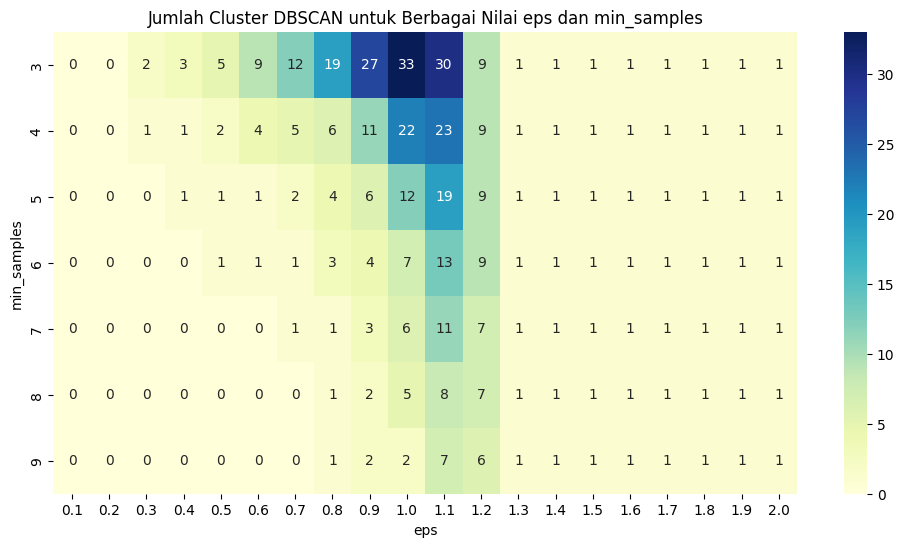

In [20]:
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters', 'n_noise', 'silhouette'])
pivot_table = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='YlGnBu')
plt.title("Jumlah Cluster DBSCAN untuk Berbagai Nilai eps dan min_samples")
plt.xlabel("eps")
plt.ylabel("min_samples")
plt.show()

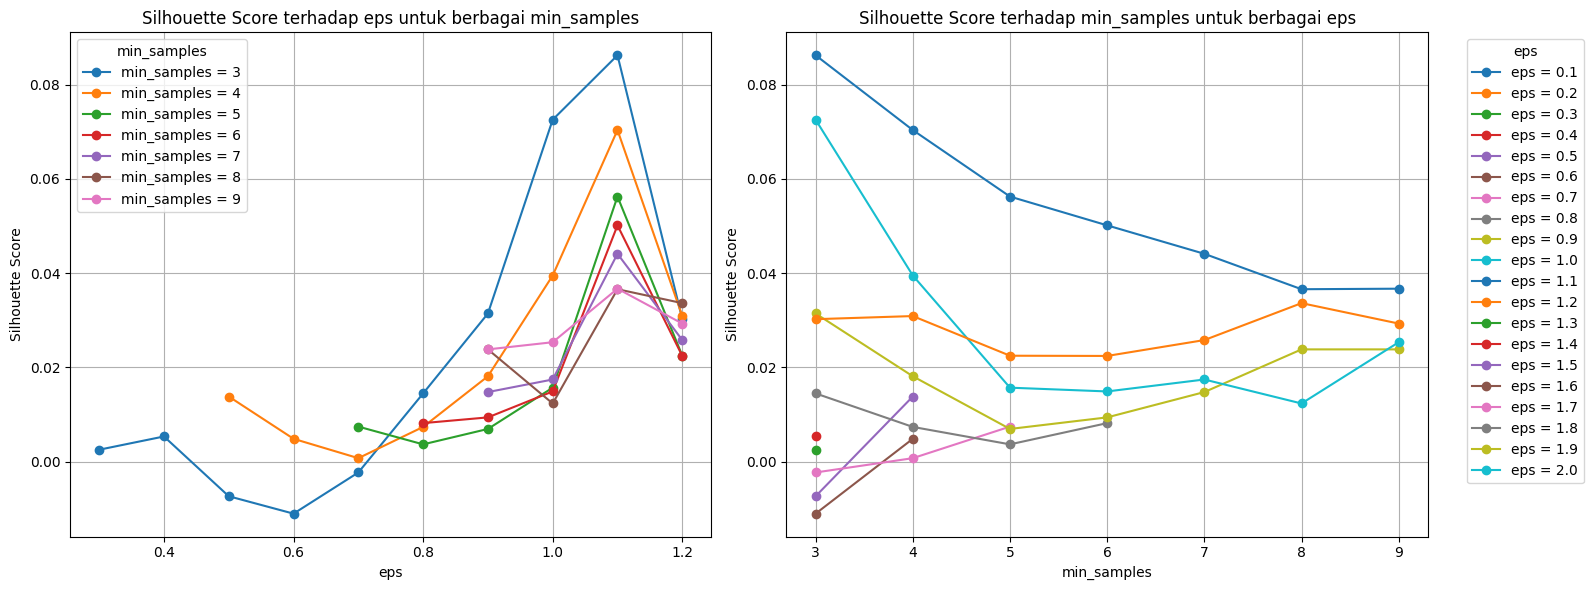

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# Plot pertama: Silhouette vs eps untuk tiap min_samples
for min_samples in results_df['min_samples'].unique():
    subset = results_df[results_df['min_samples'] == min_samples]
    axes[0].plot(subset['eps'], subset['silhouette'], marker='o', label=f'min_samples = {min_samples}')
axes[0].set_title('Silhouette Score terhadap eps untuk berbagai min_samples')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('Silhouette Score')
axes[0].legend(title='min_samples')
axes[0].grid(True)

# Plot kedua: Silhouette vs min_samples untuk tiap eps
for eps in results_df['eps'].unique():
    subset = results_df[results_df['eps'] == eps]
    axes[1].plot(subset['min_samples'], subset['silhouette'], marker='o', label=f'eps = {eps}')
axes[1].set_title('Silhouette Score terhadap min_samples untuk berbagai eps')
axes[1].set_xlabel('min_samples')
axes[1].set_ylabel('Silhouette Score')
axes[1].legend(title='eps', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## c) Build Model DBSCAN

In [46]:
dbscan = DBSCAN(eps=1.2, min_samples=9)
dbscan_labels = dbscan.fit_predict(tfidf_matrix)

label_counts = pd.Series(dbscan_labels).value_counts()
label_counts

-1    168
 2    159
 4     41
 1     31
 0     27
 5     10
 3     10
Name: count, dtype: int64

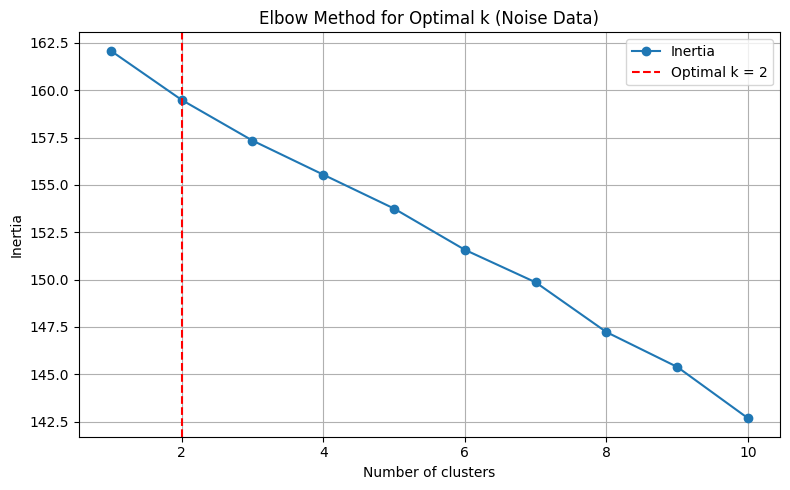

Optimal number of clusters (k) berdasarkan elbow: 2


In [47]:
noise_mask = (dbscan_labels == -1)
tfidf_noise = tfidf_matrix[noise_mask]

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_noise)
    inertia.append(kmeans.inertia_)

kneedle = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
k_optimal = kneedle.elbow

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', label='Inertia')
if k_optimal is not None:
    plt.axvline(x=k_optimal, color='red', linestyle='--', label=f'Optimal k = {k_optimal}')
plt.title('Elbow Method for Optimal k (Noise Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal number of clusters (k) berdasarkan elbow: {k_optimal}")

## d) Build Model K-Means 

In [24]:
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(tfidf_noise)

## e) Kombinasi Model DBSCAN + K-Means

In [25]:
combined_labels = dbscan_labels.copy()
max_label_dbscan = max(dbscan_labels[dbscan_labels != -1]) if any(dbscan_labels != -1) else -1
new_kmeans_labels = kmeans_labels + (max_label_dbscan + 1)

noise_indices = np.where(noise_mask)[0]
combined_labels[noise_indices] = new_kmeans_labels

df['cluster'] = combined_labels
print(df['cluster'].value_counts())

cluster
2    159
7    144
4     41
1     31
0     27
6     24
5     10
3     10
Name: count, dtype: int64


In [26]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 0
cluster_0 = df[df['cluster'] == 0][['kota', 'nama_produk', 'cluster']]
cluster_0.sample(20)

,kota,nama_produk,cluster
61,BEKASI,Pronas Bumbu Nasi Goreng Dengan Daging Sapi 11...,0
45,BEKASI,Pronas Saus Bolognese Ayam 175 g Bundling 2 Pcs,0
115,BEKASI,Pronas Leci Import 567 g dengan kemasan EOE,0
41,BEKASI,BOLOGNAISKU Saus Bolognese 250 gr,0
74,BEKASI,Pronas Kornetku Kornet Sapi 340 g bundling 2 pcs,0
93,BEKASI,PRONAS Kornet Sapi Mushroom 340 gr,0
96,BEKASI,Pronas Sosis Breakfast Kombinasi 500 gr,0
141,JAKARTA TIMUR,Villa Smoked Beef Block - Daging Sapi Asap - 2...,0
289,BEKASI,Pronas Luncheon Sapi (Daging Blok Serbaguna) 3...,0
247,JAKARTA SELATAN,Kobe Bumbu Nasi Uduk Praktis 15gr x 3pcs,0


In [ ]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 1
cluster_1 = df[df['cluster'] == 1][['kota', 'nama_produk', 'cluster']]
cluster_1.sample(20)

,kota,nama_produk,cluster
218,BEKASI,Marjan Boudoin Squash Nanas 425ml Tanpa Pengawet,1
345,CIREBON,Tong Tji Tematik Lemongrass Tea 10 s / Renceng,1
405,BEKASI,Marjan Boudoin Sirup Mocca 460ml Tanpa Pengawet,1
207,BEKASI,Marjan Boudoin Syrup Mocca 460ml,1
5,JAKARTA SELATAN,TWG Happy Birthday Tea (Gift Sets) - Teh TWG,1
181,SURABAYA,Marjan Boudoin Squash Orange 425 ml,1
266,JAKARTA UTARA,"Tong Tji Non Amplop, Original Tea Extra Harum ...",1
290,SURABAYA,Teh Javana Gula Batu Asli 350 Ml X5 Aroma Lock,1
241,SIDOARJO,"Tong Tji Super Jasmine Tea 250g, Teh Seduh per...",1
56,BOGOR,"Tong Tji Jeruk Purut 20s, Teh Celup per Pack",1


In [28]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 2
cluster_2 = df[df['cluster'] == 2][['kota', 'nama_produk', 'cluster']]
cluster_2.sample(20)

,kota,nama_produk,cluster
240,JAKARTA UTARA,Tropicana Slim Sweetener Classic 100 Sachet - ...,2
281,TANGERANG SELATAN,10 Pcs - Indomie Kuah Ayam Bawang,2
418,SURABAYA,MamaSuka - Tepung Ayam Goreng Ala Korea Garlic...,2
144,SURABAYA,Sedaap Mie Instan Goreng Kenyal Isi 5 Bag 90 Gr,2
76,JAKARTA UTARA,Paket Kecap Sehat - Topicana Slim Kecap Manis ...,2
217,SURABAYA,Frisian Flag Susu Bubuk Keluarga Fullcream 800...,2
246,SURABAYA,Top Coffee Kopi Instan White Pack 21 gr isi 10...,2
216,BEKASI,Susu UHT Rasa Coklat 115 ml,2
337,TANGERANG,Tepung Gluten Free Fried Chicken MOCAFINE - 19...,2
370,DEPOK,MADU BAJKAN- MADU BAJAKAH BORNEO - Madu Bajak...,2


In [29]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 3
cluster_3 = df[df['cluster'] == 3][['kota', 'nama_produk', 'cluster']]
cluster_3.sample(10)

,kota,nama_produk,cluster
39,DEPOK,Sido Muncul Jamu Sawanan 10's - Untuk Anak dan...,3
14,DEPOK,Sido Muncul Jamu Klingsir 10's - Air Seni Tida...,3
51,DEPOK,Sido Muncul Jamu Sakit Pinggang 10's - Nyeri P...,3
81,DEPOK,Sido Muncul Jamu Sariawan 10's - Mengobati Sar...,3
99,SIDOARJO,Sido Muncul Jamu Sehat Wanita 10's - Menyegark...,3
66,DEPOK,Sido Muncul Jamu Galian Parem 10's - Melancark...,3
67,DEPOK,Sido Muncul Jamu Ulu Hati 10's - Mengurangi Ny...,3
25,DEPOK,Sido Muncul Jamu Tujuh Angin 10's - Herbal Dem...,3
91,SIDOARJO,Sido Muncul Jamu Gemuk Sehat 10's - Herbal Mem...,3
28,DEPOK,Sido Muncul Jamu Pria Perkasa 10’s - Membantu ...,3


In [30]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 4
cluster_4 = df[df['cluster'] == 4][['kota', 'nama_produk', 'cluster']]
cluster_4.sample(20)

,kota,nama_produk,cluster
173,SIDOARJO,"Mc Lewis Barbeque Sauce 310g - Bahan Pilihan, ...",4
197,JAKARTA UTARA,Saos Cabe Dua Belibis 650ml Rasa Pedas Premium,4
311,TANGERANG SELATAN,Sambal Indofood Pedas Dahsyat 275 Ml Cabe Haba...,4
220,JAKARTA UTARA,Paket Sambal Terasi Dua Belibis 15 Gr Buy 2 Get 1,4
381,SIDOARJO,Mc Lewis Original Mayonnaise Sachet 5x100g Seg...,4
341,SURABAYA,Delmonte Saus Extra Hot Chilli 190 Ml Pedas Se...,4
18,JAKARTA TIMUR,MamaSuka - Delisaos Saus Teriyaki 320 ml,4
378,JAKARTA PUSAT,Green Valley Macaroni and Cheese Quattro Forma...,4
185,SIDOARJO,Mc Lewis Blackpepper Sauce 310g - Pedas Dan Pas,4
166,SURABAYA,Delmonte Saus Tomat Pouch 1000 gr,4


In [31]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 5
cluster_5 = df[df['cluster'] == 5][['kota', 'nama_produk', 'cluster']]
cluster_5.sample(10)

,kota,nama_produk,cluster
57,JAKARTA TIMUR,Wafer Nabati Bites Richoco White 240 gr,5
130,JAKARTA TIMUR,Nabati Cocopan 100g (PAKET ISI 5),5
7,JAKARTA TIMUR,[Bundle Pack Isi 3] Nabati Wafer Pink Lava 122g,5
436,JAKARTA BARAT,Wafello Choco Blast 10 Pcs @ 15 Gram Rasa Coke...,5
338,JAKARTA BARAT,Beng Beng Share It Pouch Cokelat Susu 10 Pcs,5
294,BEKASI,Khong Guan Classic Wafer Chocolate 350 gr x 2 Pcs,5
310,SURABAYA,Astor Double Cokelat Wafer Renyah 40 Gram,5
105,JAKARTA TIMUR,Nabati Cocopan 100g (PAKET ISI 3),5
133,JAKARTA TIMUR,Nabati Bites Richoco White 240 gr x 3Pcs,5
444,JAKARTA BARAT,Kalpa Wafer Cokelat Kelapa Renyah 22 Gram,5


In [32]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 6
cluster_6 = df[df['cluster'] == 6][['kota', 'nama_produk', 'cluster']]
cluster_6.sample(20)

,kota,nama_produk,cluster
256,SURABAYA,Potabee Keripik Kentang Grilled Seaweed 68 gr,6
277,SURABAYA,Guribee Rumput Laut 65 gr,6
348,JAKARTA PUSAT,BORGES Extra Virgin Olive Oil 250 ml Minyak Za...,6
202,JAKARTA TIMUR,"MamaSuka - Rumput Laut Panggang Isi 4 @4,5 Gr",6
342,BEKASI,Maestro Mayonais Pedas Creamy 100 Gr X2,6
211,TANGERANG SELATAN,Sunco Minyak Goreng Botol 5 L,6
255,JAKARTA PUSAT,BORGES Extra Virgin Olive Oil 125 ml Minyak Za...,6
382,SIDOARJO,Lee Kum Kee Pure Minyak Wijen Sesame Oil 750 ml,6
239,JAKARTA TIMUR,MamaSuka - Rumput Laut Panggang Pedas Isi 2 @4...,6
454,SURABAYA,Japota Keripik Kentang Nipis Pedas Sambal Bawa...,6


In [49]:
# Menampilkan hanya kolom Kota, Lokasi, dan Nama Wisata untuk cluster 7
cluster_7 = df[df['cluster'] == 7][['kota', 'nama_produk', 'cluster']]
cluster_7.sample(20)

,kota,nama_produk,cluster
372,SURABAYA,MamaSuka - Bumbu Gulai Alami Praktis 25 Gr (1 ...,7
349,BEKASI,Khong Guan Red Biscuit 1600 Gr Beragam Rasa,7
393,SIDOARJO,Sajiku Bumbu Praktis Capcay Kuah Kental 20g (5...,7
396,SURABAYA,Floridina Coco Botol 350 Ml Jus Jeruk Asli Segar,7
16,SIDOARJO,Permen Tolak Angin (Isi 50 Butir) - Masuk Angi...,7
64,JAKARTA BARAT,Safiya Kurma Ajwa 150 Gram Kurma Nabi Original,7
235,JAKARTA TIMUR,Sasa MSG 250 gr,7
156,SIDOARJO,AJI-NO-MOTO® Penyedap Rasa MSG Ajinomoto 250g,7
407,BEKASI,So Good Ayam Paha Dada Pedas Manis 450gr Tanpa...,7
274,DEPOK,SKYGOAT - Susu Kambing Etawa Bubuk SKY GOAT Ra...,7


## f) Pelabelan

In [ ]:
feature_names = vectorizer.get_feature_names_out()
cluster_keywords = {}
df = df.reset_index(drop=True)

for cluster_num in sorted(df['cluster'].unique()):
    indices = df[df['cluster'] == cluster_num].index.to_list()
    valid_indices = [i for i in indices if i < tfidf_matrix.shape[0]]
    
    if not valid_indices:
        continue 
    
    tfidf_cluster = tfidf_matrix[valid_indices]
    mean_tfidf = np.asarray(tfidf_cluster.mean(axis=0)).flatten()
    top_n = 5
    top_indices = mean_tfidf.argsort()[::-1][:top_n]
    top_keywords = [feature_names[i] for i in top_indices]
    cluster_keywords[cluster_num] = top_keywords

for cluster_num, keywords in cluster_keywords.items():
    print(f"Cluster {cluster_num}: {', '.join(keywords)}")

Cluster 0: sapi, daging, sosis, pronas, kornet
Cluster 1: teh, sirup, marjan, tea, melati
Cluster 2: susu, kopi, instan, tepung, mie
Cluster 3: obat, jamu, rhizoma, sido, muncul
Cluster 4: saus, pedas, sambal, belibis, masakan
Cluster 5: wafer, cokelat, nabati, cocopan, renyah
Cluster 6: minyak, laut, rumput, kentang, zaitun
Cluster 7: makan, bumbu, bubuk, ayam, minum


In [54]:
cluster_labels = {
    0: "Produk Olahan Daging",
    1: "Minuman Teh & Sirup",
    2: "Makanan & Minuman Sehari-hari",
    3: "Produk Herbal dan Jamu",
    4: "Saus & Bumbu Masakan",
    5: "Camilan Ringan",
    6: "Produk Segar & Bahan Mentah",
    7: "Bahan Masakan Instan"
}

df['label'] = df['cluster'].map(cluster_labels)
df.sample(5)

,link,gambar,nama_produk,harga,diskon,rating,kota,deskripsi,content,cluster,label
238,https://shopee.co.id/1-SIMBA-Sereal-Choco-Chip...,https://down-id.img.susercontent.com/file/id-1...,1 SIMBA Sereal Choco Chips Bag 950gr & 1 Choc...,8520,-14%,4.9,TANGERANG,SIMBA Sereal Choco Chips Bag adalah makanan se...,1 simba real choco chips bag 950gr 1 choco chi...,7,Bahan Masakan Instan
74,https://shopee.co.id/Pronas-Kornetku-Kornet-Sa...,https://down-id.img.susercontent.com/file/id-1...,Pronas Kornetku Kornet Sapi 340 g bundling 2 pcs,5440,-15%,4.9,BEKASI,Pronas Kornetku Kornet Sapi 340 g bundling 2 p...,pronas kornet kornet sapi 340 g bundling 2 pcs...,0,Produk Olahan Daging
394,https://shopee.co.id/1-Karton-Tropicana-Slim-O...,https://down-id.img.susercontent.com/file/id-1...,1 Karton - Tropicana Slim Oat Drink 190 ml (RT...,16900,-33%,4.9,JAKARTA UTARA,Tropicana Slim Oat Drink adalah minuman oat be...,1 karton tropicana slim oat drink 190 ml rtd 2...,2,Makanan & Minuman Sehari-hari
393,https://shopee.co.id/Sajiku%C2%AE-Bumbu-Prakti...,https://down-id.img.susercontent.com/file/id-1...,Sajiku Bumbu Praktis Capcay Kuah Kental 20g (5...,1000,0%,4.9,SIDOARJO,Sajiku Bumbu Sayur Capcay adalah bumbu praktis...,saji bumbu praktis capcay kuah kental 20g 5 pc...,7,Bahan Masakan Instan
111,https://shopee.co.id/Pronas-Jagung-Manis-Cream...,https://down-id.img.susercontent.com/file/c01e...,Pronas Jagung Manis Creamy 410 g,1950,-19%,4.9,BEKASI,Pronas Jagung Manis Creamy 410 g adalah sayura...,pronas jagung manis creamy 410 g pronas jagung...,7,Bahan Masakan Instan


## g) Evaluasi dan Visualisasi Model

In [34]:
X_dbscan = tfidf_matrix
dbscan_labels_eval = dbscan_labels.copy()
if -1 in dbscan_labels:
    dbscan_labels_eval[dbscan_labels_eval == -1] = dbscan_labels.max() + 1

X_combined = tfidf_matrix
labels_combined = combined_labels

# Menghitung Silhouette Score
silhouette_dbscan = silhouette_score(X_dbscan, dbscan_labels_eval)
silhouette_combined = silhouette_score(X_combined, labels_combined)

# Menghitung Davies-Bouldin Score
dbs_dbscan = davies_bouldin_score(X_dbscan.toarray(), dbscan_labels_eval)
dbs_combined = davies_bouldin_score(X_combined.toarray(), labels_combined)

comparison_scores = pd.DataFrame({
    'Clustering Method': ['DBSCAN', 'Kombinasi DBSCAN + KMeans'],
    'Silhouette Score': [silhouette_dbscan, silhouette_combined],
    'Davies-Bouldin Score': [dbs_dbscan, dbs_combined]
})

comparison_scores

,Clustering Method,Silhouette Score,Davies-Bouldin Score
0,DBSCAN,0.029304,4.942664
1,Kombinasi DBSCAN + KMeans,0.032148,4.892831


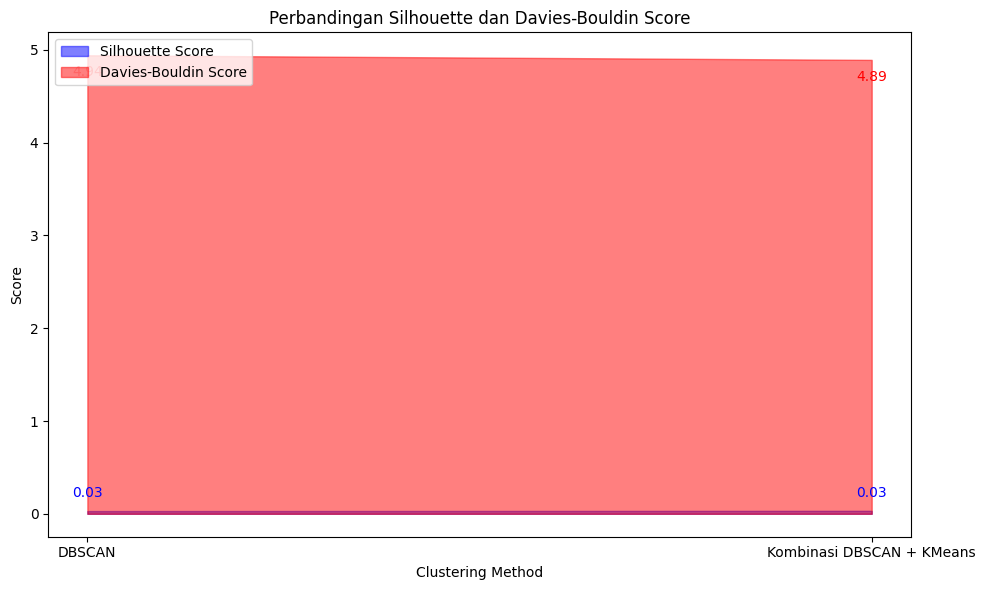

In [35]:
methods = ['DBSCAN', 'Kombinasi DBSCAN + KMeans']
silhouette_scores = [silhouette_dbscan, silhouette_combined]
db_scores = [dbs_dbscan, dbs_combined]

fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(methods, silhouette_scores, color='b', alpha=0.5, label='Silhouette Score')
ax.fill_between(methods, db_scores, color='r', alpha=0.5, label='Davies-Bouldin Score')

for i, txt in enumerate(silhouette_scores):
    ax.annotate(f'{txt:.2f}', (methods[i], silhouette_scores[i]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

for i, txt in enumerate(db_scores):
    ax.annotate(f'{txt:.2f}', (methods[i], db_scores[i]), textcoords="offset points", xytext=(0,-15), ha='center', color='red')

ax.set_xlabel('Clustering Method')
ax.set_ylabel('Score')
ax.set_title('Perbandingan Silhouette dan Davies-Bouldin Score')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

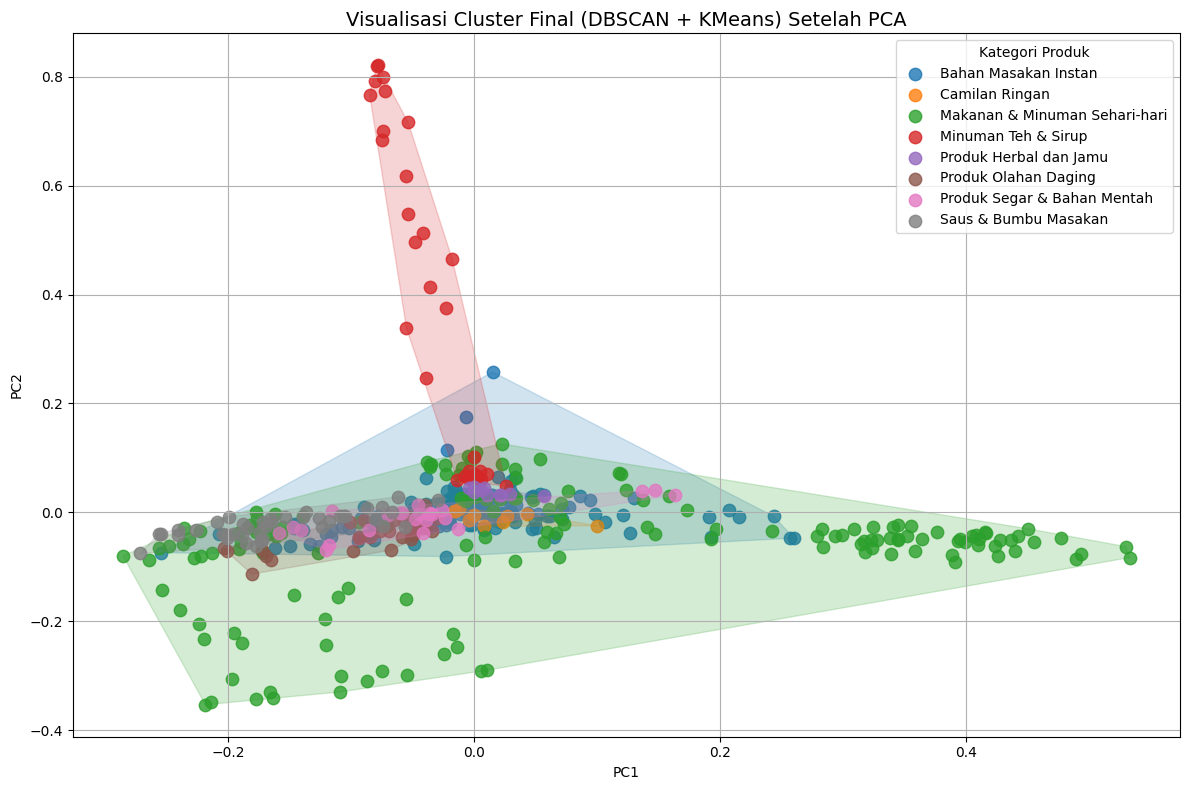

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_combined.toarray())  

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = labels_combined  
pca_df['label'] = pca_df['cluster'].map(cluster_labels)  #

plt.figure(figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
unique_labels = sorted(pca_df['label'].unique())

for i, label in enumerate(unique_labels):
    cluster_points = pca_df[pca_df['label'] == label]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'],
                label=label, s=80, alpha=0.8,
                color=colors[i % len(colors)])
    
    if len(cluster_points) > 2:
        try:
            hull = ConvexHull(cluster_points[['PC1', 'PC2']].values)
            hull_vertices = cluster_points.iloc[hull.vertices]
            plt.fill(hull_vertices['PC1'], hull_vertices['PC2'],
                     color=colors[i % len(colors)], alpha=0.2)
        except:
            pass

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualisasi Cluster Final (DBSCAN + KMeans) Setelah PCA', fontsize=14)
plt.legend(title='Kategori Produk', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_combined.toarray())
pca_3d_df = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['cluster'] = labels_combined
pca_3d_df['label'] = pca_3d_df['cluster'].map(cluster_labels)

fig = px.scatter_3d(
    pca_3d_df, 
    x='PC1', y='PC2', z='PC3', 
    color='label',  
    labels={'PC1': 'PC1', 'PC2': 'PC2', 'PC3': 'PC3', 'label': 'Kategori Produk'},
    title='Visualisasi Cluster Final (DBSCAN + KMeans) Setelah PCA 3D'
)

fig.show()

# **Menyimpan TF-IDF Matrix**

In [73]:
import pickle

with open('model/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('model/tfidf_matrix.pkl', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

df.to_csv('data/final_clean_data.csv', index=False)